In [4]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from urllib.parse import urlparse, parse_qsl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import django
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import normalize

In [34]:
import nltk
from nltk.stem import SnowballStemmer
import string

stoplist = set(nltk.corpus.stopwords.words("english"))
stoplist.add('elsevier')
stoplist.add('rights')
stoplist.add('reserved')
stoplist.add('john')
stoplist.add('wiley')
stoplist.add('sons')
stoplist.add('copyright')

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    tokens = [i for i in tokens if i not in string.punctuation]
    return tokens

class snowball_stemmer(object):
    def __init__(self):
        self.stemmer = SnowballStemmer("english")
    def __call__(self, doc):
        return [self.stemmer.stem(t) for t in tokenize(doc)]

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   tokenizer=snowball_stemmer(),
                                   stop_words=stoplist)

c_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=stoplist, tokenizer=snowball_stemmer())



In [39]:
all_ys = range(0,100000)
q = Query.objects.get(pk=2355)
X = []
ars = AR.objects.filter(ar__gt=0)
for ar in ars:
    abstracts = []
    ys = range(ar.start,ar.end+1)
    ydocs = Doc.objects.filter(query=q,PY__in=ys)
    abdocs = ydocs.filter(content__iregex='\w')
    tidocs = ydocs.exclude(content__iregex='\w')
    #ydocs = Doc.objects.filter(query=q,PY__in=ys,content__iregex='\w')
    #ydocs = Doc.objects.filter(query=q,PY__in=ys)#,content__iregex='\w')
    abstracts = list(abdocs.values_list('content',flat=True)) + list(tidocs.values_list('title',flat=True))
    X_y = c_vectorizer.fit_transform(abstracts)
    X.append(X_y)
    print(X_y.shape)

(1848, 2834)
(6941, 13279)
(18728, 26663)
(44000, 49960)
(108277, 92377)
(128357, 108103)


,Documents,Terms
0,1848,3528
1,6941,15781
2,18728,27730
3,44000,45388
4,108277,75552
5,128357,86149
6,1189,11977


In [29]:
AR.objects.values()

<QuerySet [{'ar': 0, 'end': 1984, 'start': 0, 'name': 'AR0', 'id': 6}, {'ar': 1, 'end': 1990, 'start': 1985, 'name': 'AR1', 'id': 1}, {'ar': 2, 'end': 1994, 'start': 1991, 'name': 'AR2', 'id': 2}, {'ar': 3, 'end': 2000, 'start': 1995, 'name': 'AR3', 'id': 3}, {'ar': 4, 'end': 2007, 'start': 2001, 'name': 'AR4', 'id': 4}, {'ar': 5, 'end': 2013, 'start': 2008, 'name': 'AR5', 'id': 5}, {'ar': 6, 'end': 9998, 'start': 2014, 'name': 'AR6', 'id': 7}]>

In [30]:
import codecs
import re
bible = []
i=0
clines=""
corpus = []
lchapter="none"
with codecs.open('/home/galm/projects/big_literature/py/Martin_Luther_Uebersetzung_1912.txt',encoding = "ISO-8859-1") as ml:
    for line in ml:
        chapter = line.split(':')[0]
        try:
            verse = re.search(".*([0-9]+\:[0-9]*)(.*)",line).group(2).strip()
        except:
            corpus.append(str(clines))
            break
        if lchapter!=chapter and i > 0:
            corpus.append(str(clines))
            clines=verse            
        else:
            clines+=" "+verse
            #print('\n')
        lchapter = chapter
        i+=1
        
X_y = c_vectorizer.fit_transform(corpus)
X.append(X_y)

#8dd3c7
0.3085629041498874
#ffffb3
0.31788209957571556
#bebada
0.3855741207185674
#fb8072
0.5044386008906278
#80b1d3
0.6919554309312901
#fdb462
0.7470281575558009


IndexError: index 6 is out of bounds for axis 0 with size 6

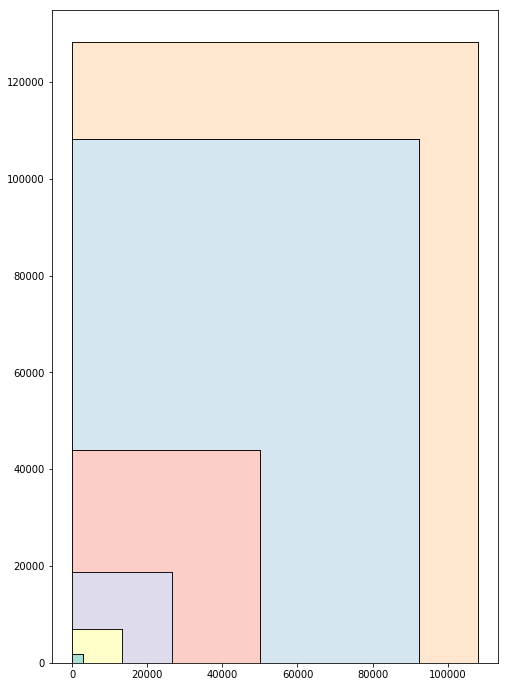

In [38]:
ind = np.arange(1)

plt.rcParams["figure.figsize"] = [8,12]

def vvrect(X,col_x,m):
    return plt.bar(ind+X.shape[1]/2,X.shape[0],width=X.shape[1],facecolor=col_x,edgecolor='black',alpha=m)#,alpha=m)

means = [x.getnnz(0).mean()/x.shape[0]*100 for x in X]
nmeans = normalize([means])[0]

crange = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc']

crange = ["#D53E4F", "#FC8D59", "#FEE08B", "#E6F598", "#99D594", "#3288BD"]

crange = ["#8dd3c7","#ffffb3","#bebada","#fb8072","#80b1d3","#fdb462","grey"]

years = [x.name for x in ars] + ["Bible"]



plots = []
lvalues = []
for x in [5,4,3,2,1,0,6]:
    a = (nmeans[x]+0.3)/1.3
    #a = nmeans[x]
    vvrect(X[x], "None",1)
    vvrect(X[x], "white",1)
    p = vvrect(X[x], crange[x] ,a)
    plots.append(p[0])
    lvalues.append(years[x] + ": " + str(round(means[x],2)))
    print(crange[5-x])
    print(a)
    
plt.legend(plots,lvalues,title='% of documents mean term appears in')
    
plt.axis('equal')
plt.ylabel('Documents')
plt.xlabel('Words')
plt.savefig('../plots/volume_variety.png',bbox_inches='tight')

plt.show()


In [37]:
tab = pd.DataFrame([(x.shape[0],x.shape[1]) for x in X]).rename({0:'Documents',1:'Terms'},axis="columns")
tab.index = years
tab['Average Document score per Term'] = means
tab

ValueError: Length mismatch: Expected axis has 6 elements, new values have 7 elements

[]
(-1000.0, 97149.0)


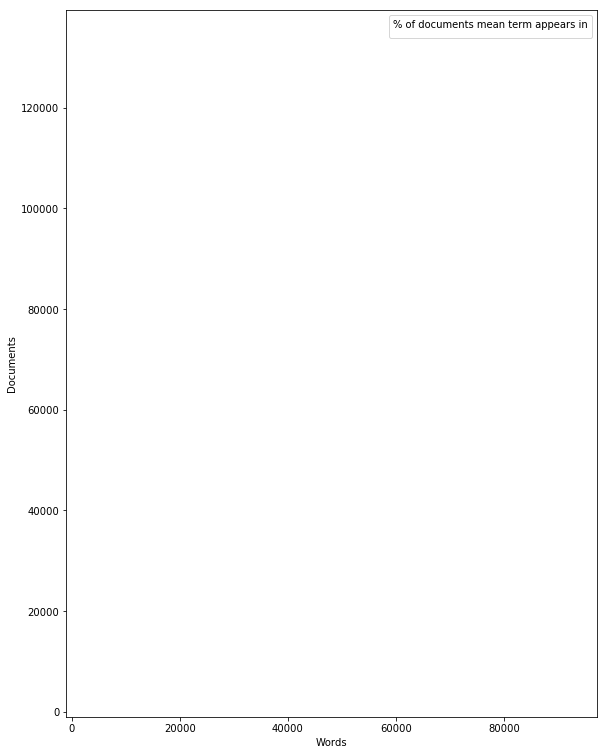

[0]
(-1000.0, 97149.0)


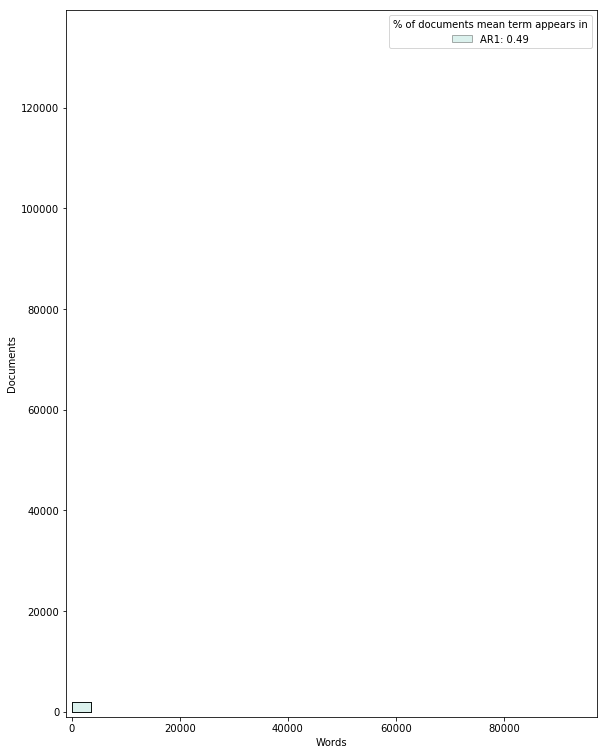

[1, 0]
(-1000.0, 97149.0)


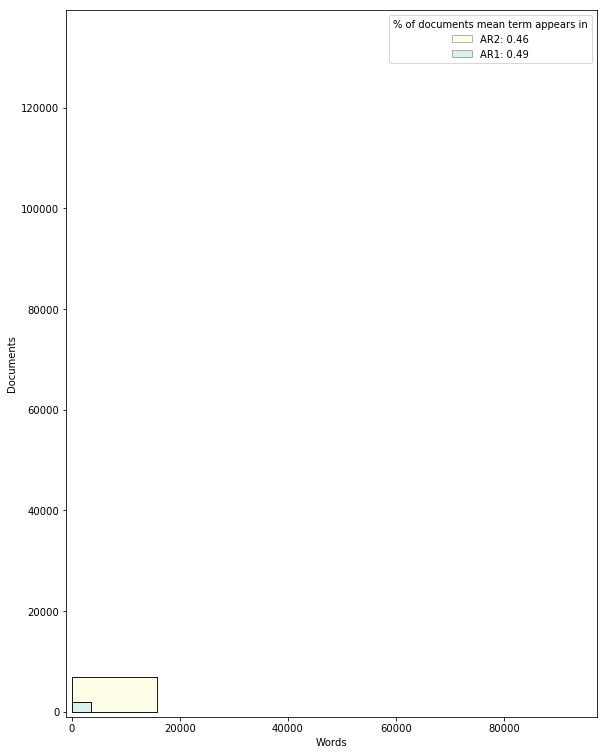

[2, 1, 0]
(-1000.0, 97149.0)


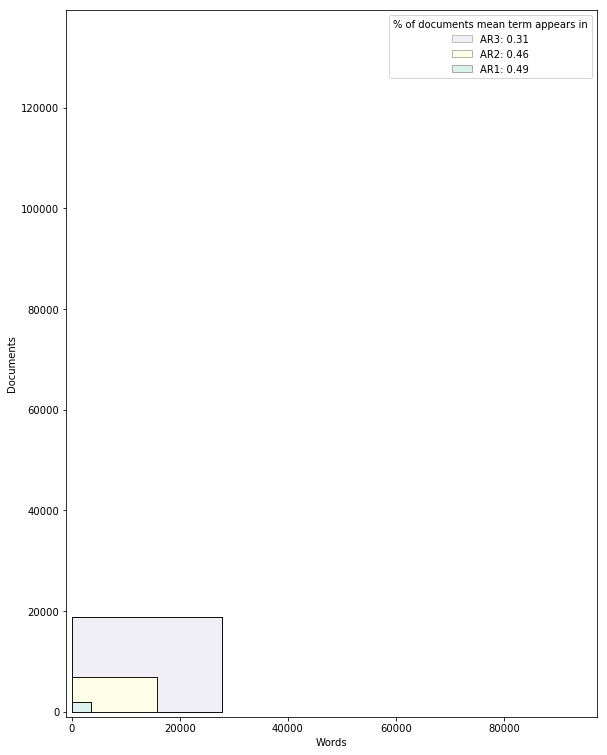

[3, 2, 1, 0]
(-1000.0, 97149.0)


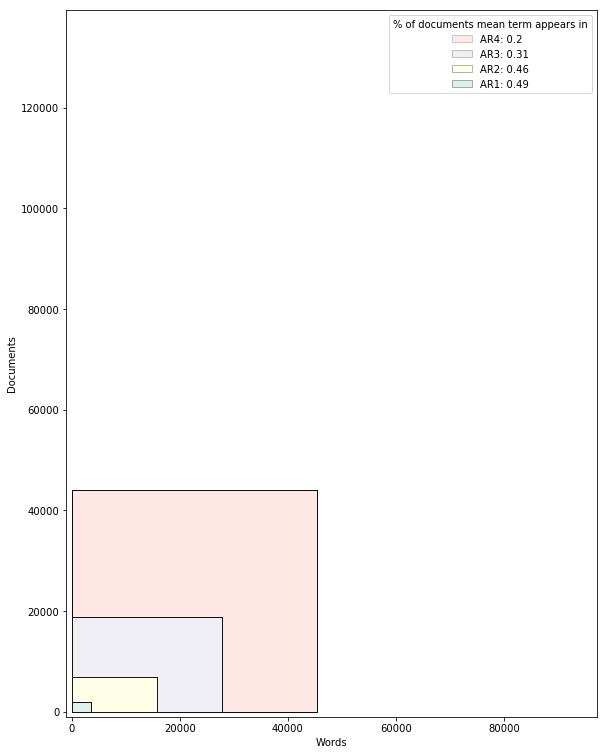

[4, 3, 2, 1, 0]
(-1000.0, 97149.0)


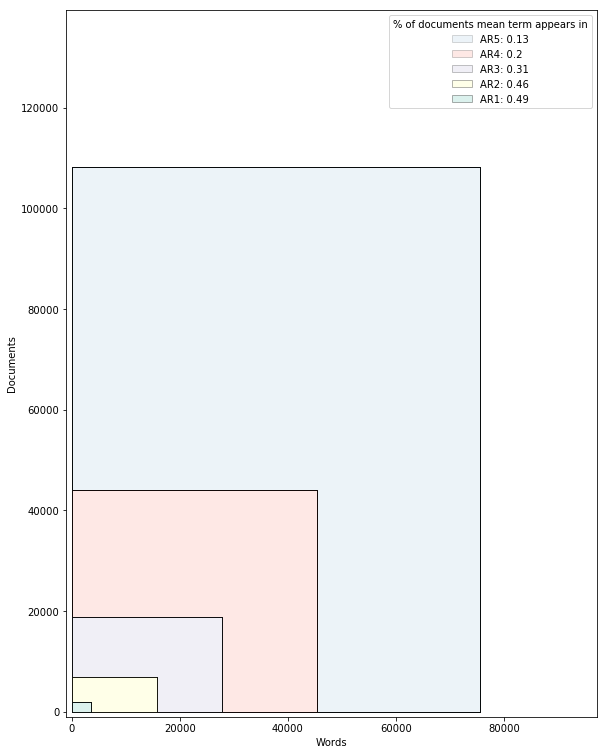

[5, 4, 3, 2, 1, 0]
(-1000.0, 97149.0)


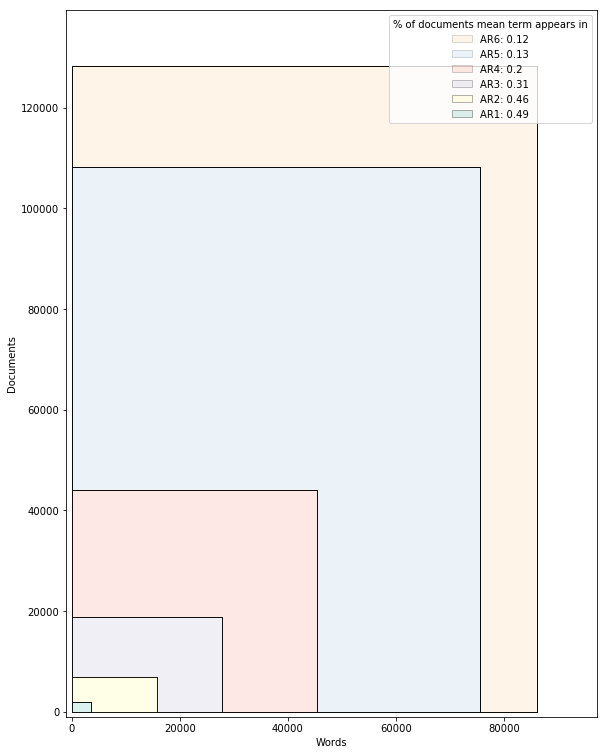

In [38]:



shape = [(x+6000)/10000 for x in list(X[5].shape)[::1]]

plt.rcParams["figure.figsize"] = tuple([round(x) for x in shape[::1]])

plt.rcParams["figure.figsize"] = (9.5,13)

xs = [5,4,3,2,1,0,6]

for ar in AR.objects.all():
    
    iprs = IPCCRef.objects.filter(ar=ar).count()
    
    plots = []
    lvalues = []

    ar_xs = [x for x in xs if ar.ar > x ]
    print(ar_xs)
    #continue
    for x in ar_xs:
        a = (nmeans[x]+0.1)/1.1
        #a = nmeans[x]
        vvrect(X[x], "None",1)
        vvrect(X[x], "white",1)
        p = vvrect(X[x], crange[x] ,a)
        plots.append(p[0])
        lvalues.append(years[x] + ": " + str(round(means[x],2)))
        ar = AR.objects.get(ar=x+1)
        iprs = IPCCRef.objects.filter(ar=ar).count()
        xtent = shape[1]*10000+5000+1000
        #plt.axhline(iprs,xmin=1/xtent*1000,xmax=1/xtent*(X[x].shape[1]+1000))
    
    plt.legend(plots,lvalues,title='% of documents mean term appears in')
    
    #plt.axis('equal')

    #plt.ylim((-1000,130000))
    #plt.ylim(ymin=-1000)
    #plt.xlim((-1000,100000))
    plt.xlim((-1000,shape[1]*10000+5000))
    plt.ylim((-1000,shape[0]*10000+5000))
    #plt.ylim(ymax=shape[0]*10000)
    #plt.xlim(xmax=shape[1]*10000)
    plt.ylabel('Documents')
    plt.xlabel('Words')
    plt.savefig('../plots/volume_variety_{}.png'.format(ar.name),bbox_inches='tight')
    
    print(plt.xlim())

    plt.show()


[0, 6]
#fdb462
0.310011853518
grey
0.930005541459
(-1000.0, 97149.0)


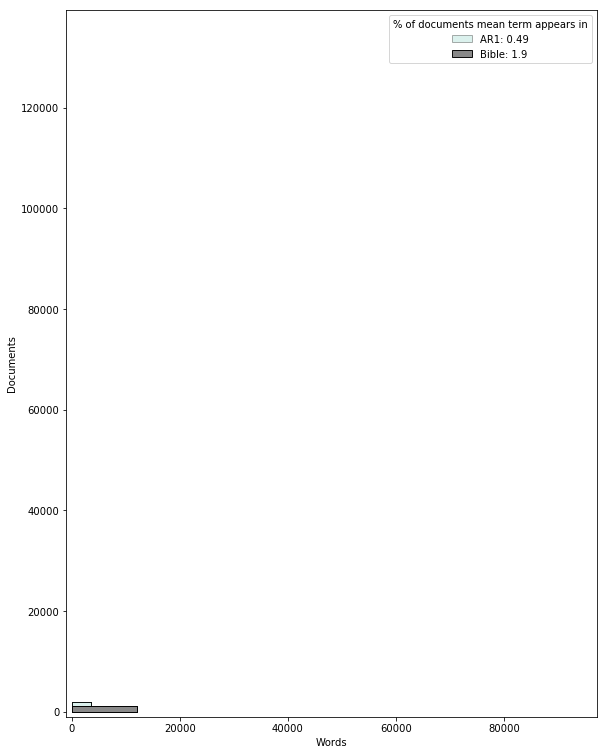

[1, 0, 6]
#80b1d3
0.295764452633
#fdb462
0.310011853518
grey
0.930005541459
(-1000.0, 97149.0)


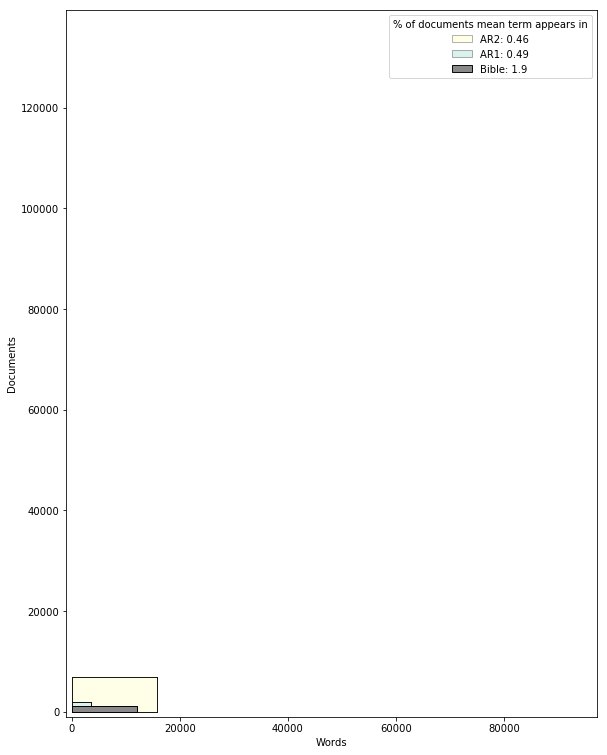

[2, 1, 0, 6]
#fb8072
0.228079155109
#80b1d3
0.295764452633
#fdb462
0.310011853518
grey
0.930005541459
(-1000.0, 97149.0)


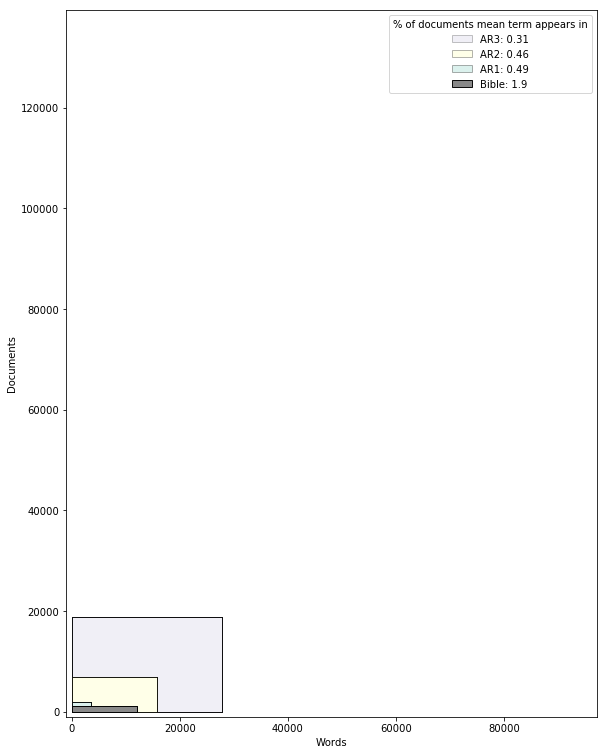

[3, 2, 1, 0, 6]
#bebada
0.17953493415
#fb8072
0.228079155109
#80b1d3
0.295764452633
#fdb462
0.310011853518
grey
0.930005541459
(-1000.0, 97149.0)


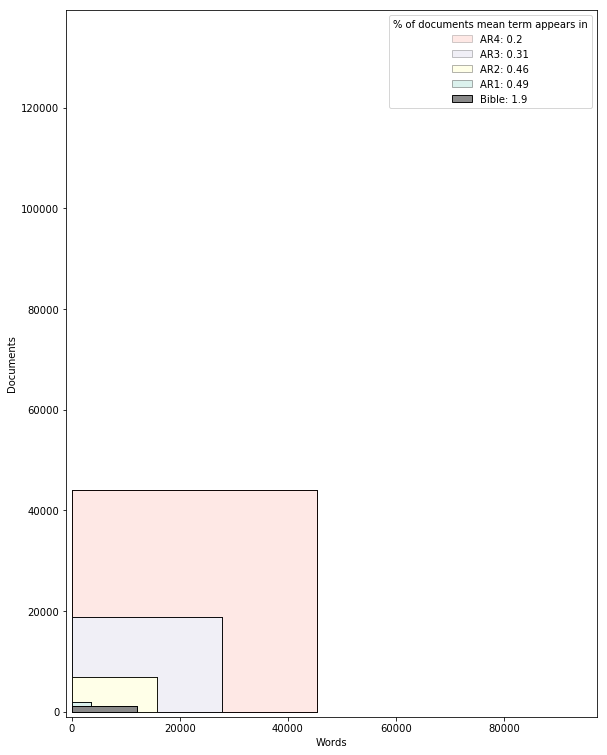

[4, 3, 2, 1, 0, 6]
#ffffb3
0.146549061626
#bebada
0.17953493415
#fb8072
0.228079155109
#80b1d3
0.295764452633
#fdb462
0.310011853518
grey
0.930005541459
(-1000.0, 97149.0)


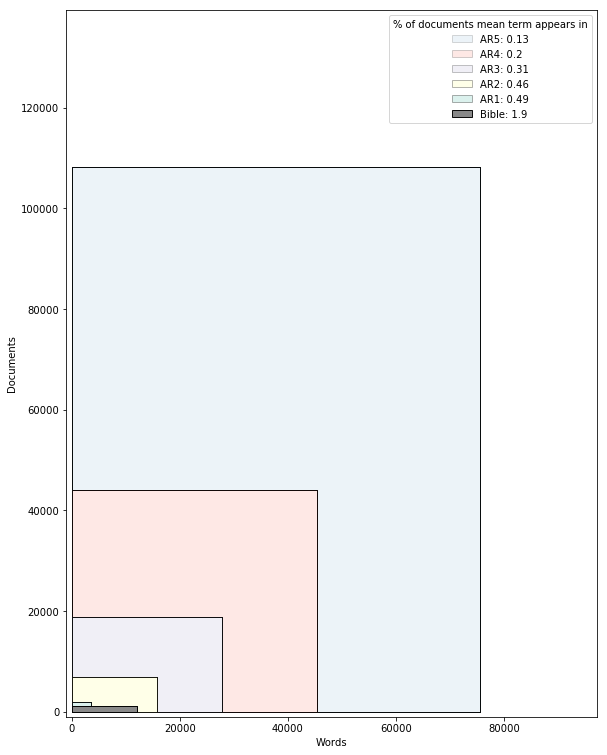

[5, 4, 3, 2, 1, 0, 6]
#8dd3c7
0.142150821096
#ffffb3
0.146549061626
#bebada
0.17953493415
#fb8072
0.228079155109
#80b1d3
0.295764452633
#fdb462
0.310011853518
grey
0.930005541459
(-1000.0, 97149.0)


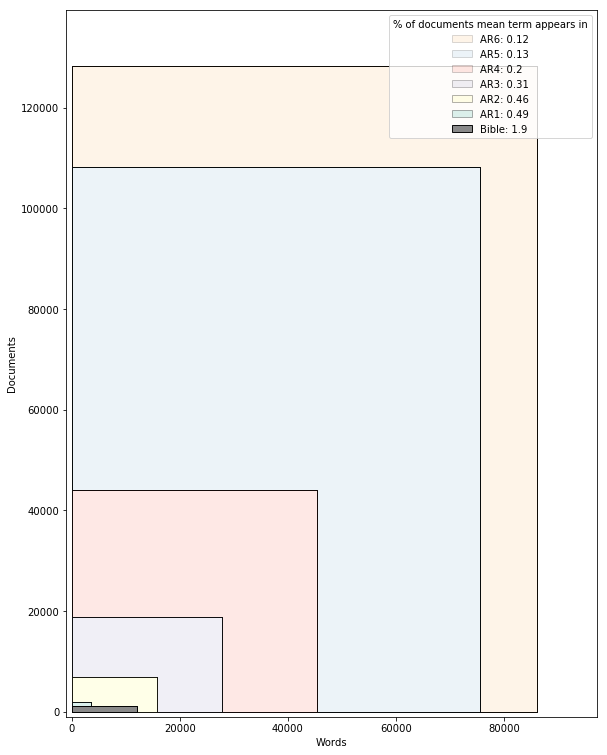

In [34]:
for ar in ars:
    plots = []
    lvalues = []

    ar_xs = [x for x in xs if ar.ar > x or x ==6]
    print(ar_xs)
    #continue
    for x in ar_xs:
        a = (nmeans[x]+0.1)/1.1
        #a = nmeans[x]
        vvrect(X[x], "None",1)
        vvrect(X[x], "white",1)
        p = vvrect(X[x], crange[x] ,a)
        plots.append(p[0])
        #lvalues.append(years[x] + ": " + str(round(X[x].mean()*1000000/X[x].sum(),5)))
        lvalues.append(years[x] + ": " + str(round(means[x],2)))
        print(crange[5-x])
        print(a)
    
    plt.legend(plots,lvalues,title='% of documents mean term appears in')
    
    #plt.axis('equal')

    #plt.ylim((-1000,130000))
    #plt.ylim(ymin=-1000)
    #plt.xlim((-1000,100000))
    plt.xlim((-1000,shape[1]*10000+5000))
    plt.ylim((-1000,shape[0]*10000+5000))
    #plt.ylim(ymax=shape[0]*10000)
    #plt.xlim(xmax=shape[1]*10000)
    plt.ylabel('Documents')
    plt.xlabel('Words')
    plt.savefig('../plots/volume_variety_bible_{}.png'.format(ar.name),bbox_inches='tight')
    
    print(plt.xlim())

    plt.show()



In [9]:
means

nmeans

array([ 0.24101304,  0.2253409 ,  0.15088707,  0.09748843,  0.06120397,
        0.05636587,  0.9230061 ])

In [10]:
for x in xs:
    print(X[x].sum(0).mean())
    print(X[x].sum(0).mean()/X[x].shape[0]*100)
    print(X[x].shape)
    print('\n\n')
    
    

212.216450568
0.165332977997
(128357, 86149)



192.787301629
0.178050095246
(108277, 75553)



125.506763902
0.285242645233
(44000, 45388)



82.9813919942
0.443087313083
(18728, 27730)



44.7941828781
0.645356330185
(6941, 15781)



11.7545351474
0.636067919231
(1848, 3528)



48.1242796292
4.04745833719
(1189, 11973)





In [11]:
for x in xs:
    print(X[x].getnnz(0).mean())
    print(X[x].getnnz(0).mean()/X[x].shape[0]*100)
    print(X[x].shape)
    print('\n\n')
    

148.558102822
0.11573821671
(128357, 86149)



136.074384869
0.125672474181
(108277, 75553)



88.0777738609
0.200176758775
(44000, 45388)



58.0235124414
0.309822257803
(18728, 27730)



32.1160889677
0.462701180921
(6941, 15781)



9.14540816327
0.494881394116
(1848, 3528)



22.5344525182
1.89524411423
(1189, 11973)





In [12]:
X_y.sum(0).mean()


48.124279629165621